In [1]:
# IMPORTS

# data manipulation and analysis
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# model
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# warings
import warnings
warnings.filterwarnings('ignore')

# set random seed for reproducibility
np.random.seed(42)

#### 1. Data Loading

In [8]:
# loading the train and validation datasets
X_train = pd.read_csv('../Data/breast_cancer_trainset.csv').drop(columns=['diagnosis'])
y_train = pd.read_csv('../Data/breast_cancer_trainset.csv')['diagnosis']

X_val = pd.read_csv('../Data/breast_cancer_valset.csv').drop(columns=['diagnosis'])
y_val = pd.read_csv('../Data/breast_cancer_valset.csv')['diagnosis']

# data dimensions
print("Data Split Dimensions:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

# target Distribution
print("-"*60)
print("Target Distribution:")
print(f"Train: {(y_train==0).sum()/len(y_train)*100:.1f}% Benign (0), {(y_train==1).sum()/len(y_train)*100:.1f}% Malignant (1)")
print(f"Validation: {(y_val==0).sum()/len(y_val)*100:.1f}% Benign (0), {(y_val==1).sum()/len(y_val)*100:.1f}% Malignant (1)")
print("-"*60)

Data Split Dimensions:
X_train: (398, 30)
y_train: (398,)
X_val: (57, 30)
y_val: (57,)
------------------------------------------------------------
Target Distribution:
Train: 62.6% Benign (0), 37.4% Malignant (1)
Validation: 63.2% Benign (0), 36.8% Malignant (1)
------------------------------------------------------------


#### 2. Baseline XGBoost Model (Default Parameters)

##### The purpose of creating a baseline model is to have a benchmark for comparing the performance of the tuned model. This will help us understand if the tuning process is effective

Baseline XGBoost Pipeline - Validation Set Performance
Accuracy: 0.9825
Precision: 1.0000
Recall: 0.9524
F1 Score: 0.9756
ROC AUC: 0.9987
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       1.00      0.95      0.98        21

    accuracy                           0.98        57
   macro avg       0.99      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57



Text(0.5, 36.72222222222221, 'Predicted')

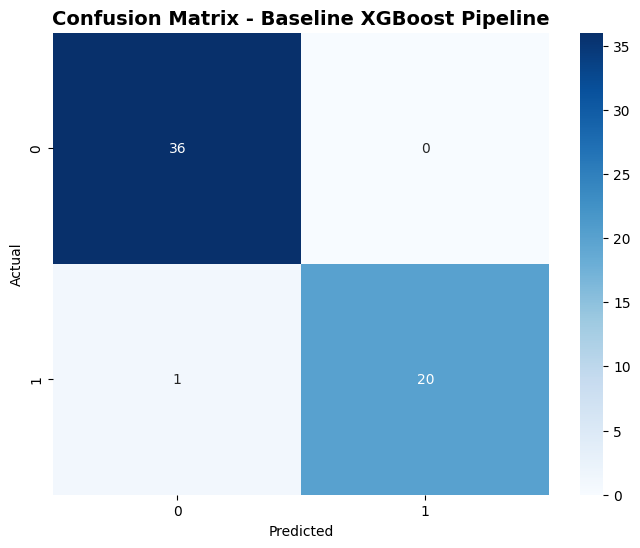

In [ ]:
# Baseline XGBoost Model with Pipeline

# Create pipeline: XGBoost
xgb_baseline_pipeline = Pipeline([
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Train on training data
xgb_baseline_pipeline.fit(X_train, y_train)

# Make predictions on RAW validation data (pipeline handles scaling automatically)
y_val_pred = xgb_baseline_pipeline.predict(X_val)
y_val_pred_proba = xgb_baseline_pipeline.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred_proba)

# Print results
print(f"Baseline XGBoost Pipeline - Validation Set Performance")
print("=" * 50)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("-" * 50)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline XGBoost Pipeline', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')

##### The ROC (Receiver Operating Characteristic) curve visualizes the trade-off between the True Positive Rate (sensitivity/recall) and False Positive Rate (1-specificity) across all possible classification thresholds. The curve shows how well the model distinguishes between the two classes (benign vs malignant tumors) at different probability cutoffs.

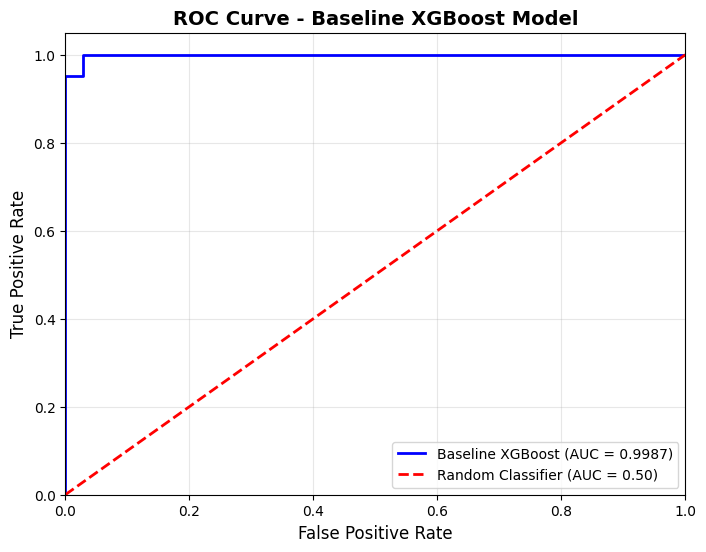

In [13]:
# ROC Curve for Baseline Model
fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(y_val, y_val_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_baseline, tpr_baseline, color='blue', lw=2, label=f'Baseline XGBoost (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Baseline XGBoost Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

#### 3. Hyperparameter tuning with GridSearhCV and Cross-Validation

The purpose of hyperparameter tuning is to find the best combination of hyperparameters for the model to improve its performance. We first define a range of hyperparameters to search through. Then, we use GridSearchCV to search through the hyperparameters and find the best combination. We use Cross-Validation to then evaluate the performance of the model with the best hyperparameters. We use recall as the scoring metric because in the context of breast cancer classification, we want to minimize the false negatives.

In [ ]:
# Create pipeline for hyperparameter tuning
xgb_pipeline = Pipeline([
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Parameter grid
param_grid_pipeline = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__gamma': [0, 0.1, 0.2]
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with pipeline
grid_search_pipeline = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_pipeline,
    cv=cv_strategy,
    scoring='recall',
    n_jobs=-1,
    verbose=2
)

# Fit on raw training data
grid_search_pipeline.fit(X_train, y_train)

print(f"Best parameters: {grid_search_pipeline.best_params_}")
print(f"Best Cross-Validation Recall Score: {grid_search_pipeline.best_score_:.4f}")


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.0s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.0s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.1s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.1s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.1s
[CV] END xgb__colsample_bytree=0.8, 

#### 4. Training final model with best parameters on full training set

Now that we have the best parameters, we can train the final model on the full training set.

COMPARISON: BASELINE VS TUNED MODEL
Metric          Baseline        Tuned           Change         
------------------------------------------------------------
Accuracy        0.9825           0.9825           +0.0000
Precision       1.0000           0.9545           -0.0455
Recall          0.9524           1.0000           +0.0476
F1-Score        0.9756           0.9767           +0.0011
ROC-AUC         0.9987           1.0000           +0.0013

Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.95      1.00      0.98        21

    accuracy                           0.98        57
   macro avg       0.98      0.99      0.98        57
weighted avg       0.98      0.98      0.98        57



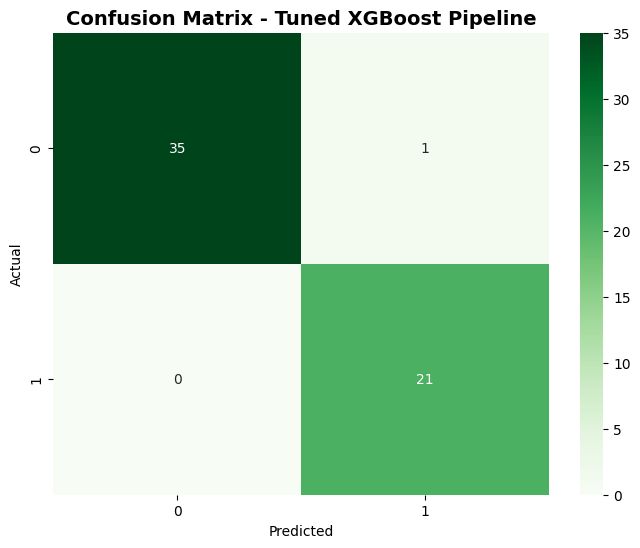

In [11]:
xgb_tuned_pipeline = grid_search_pipeline.best_estimator_

# making predictions on validation set
y_val_pred_tuned = xgb_tuned_pipeline.predict(X_val)
y_val_pred_proba_tuned = xgb_tuned_pipeline.predict_proba(X_val)[:, 1]

# Calculating metrics
accuracy_tuned = accuracy_score(y_val, y_val_pred_tuned)
precision_tuned = precision_score(y_val, y_val_pred_tuned)
recall_tuned = recall_score(y_val, y_val_pred_tuned)
f1_tuned = f1_score(y_val, y_val_pred_tuned)
roc_auc_tuned = roc_auc_score(y_val, y_val_pred_proba_tuned)

# Comparison
print("=" * 60)
print("COMPARISON: BASELINE VS TUNED MODEL")
print("=" * 60)
print(f"{'Metric':<15} {'Baseline':<15} {'Tuned':<15} {'Change':<15}")
print("-" * 60)
print(f"{'Accuracy':<15} {accuracy:.4f}{'':<10} {accuracy_tuned:.4f}{'':<10} {(accuracy_tuned-accuracy):+.4f}")
print(f"{'Precision':<15} {precision:.4f}{'':<10} {precision_tuned:.4f}{'':<10} {(precision_tuned-precision):+.4f}")
print(f"{'Recall':<15} {recall:.4f}{'':<10} {recall_tuned:.4f}{'':<10} {(recall_tuned-recall):+.4f}")
print(f"{'F1-Score':<15} {f1:.4f}{'':<10} {f1_tuned:.4f}{'':<10} {(f1_tuned-f1):+.4f}")
print(f"{'ROC-AUC':<15} {roc_auc:.4f}{'':<10} {roc_auc_tuned:.4f}{'':<10} {(roc_auc_tuned-roc_auc):+.4f}")
print("=" * 60)

# Classification Report
print("\nTuned Model Classification Report:")
print(classification_report(y_val, y_val_pred_tuned))

# Confusion Matrix
cm_tuned = confusion_matrix(y_val, y_val_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Tuned XGBoost Pipeline', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

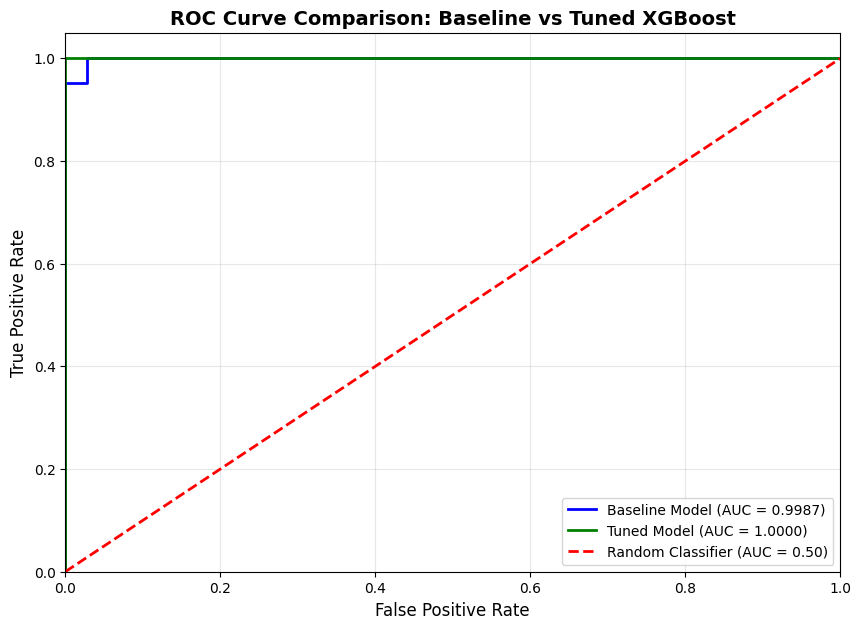

In [14]:
# ROC Curve Comparison: Baseline vs Tuned
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_val, y_val_pred_proba_tuned)

plt.figure(figsize=(10, 7))
plt.plot(fpr_baseline, tpr_baseline, color='blue', lw=2, label=f'Baseline Model (AUC = {roc_auc:.4f})')
plt.plot(fpr_tuned, tpr_tuned, color='green', lw=2, label=f'Tuned Model (AUC = {roc_auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: Baseline vs Tuned XGBoost', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

#### 5. Feature Importance Analysis

##### Now that we have trained the best model on the full training set, we can analyze the feature importance.


Top 10 Features by Importance:
                 Feature  Importance
20          radius_worst    0.310335
23            area_worst    0.213247
22       perimeter_worst    0.086589
7    concave points_mean    0.068204
27  concave points_worst    0.048597
6         concavity_mean    0.044786
26       concavity_worst    0.041108
24      smoothness_worst    0.024238
21         texture_worst    0.021236
1           texture_mean    0.017177


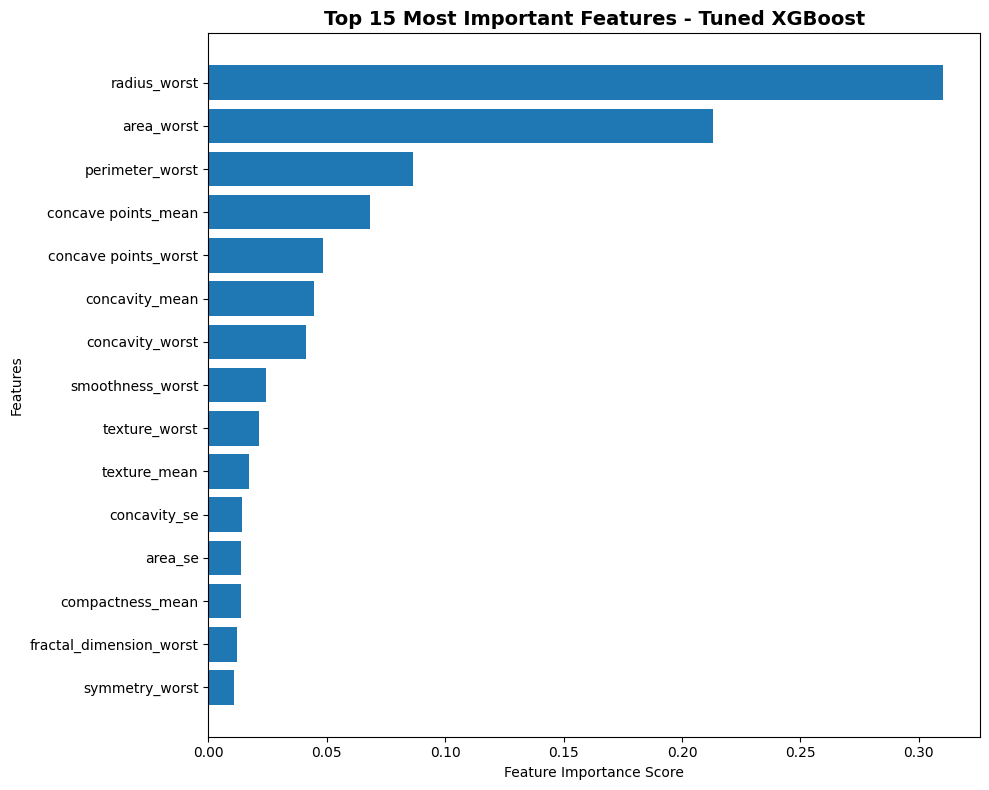

In [12]:
# Extract XGBoost model from pipeline and get feature importances
xgb_model_from_pipeline = xgb_tuned_pipeline.named_steps['xgb']
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model_from_pipeline.feature_importances_
}).sort_values(by='Importance', ascending=False)

# displaying top 10 features
print("\nTop 10 Features by Importance:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 15 Most Important Features - Tuned XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### 6. Summary and Model Selection

After experimentation with XGBoost for breast cancer classification, we trained and evaluated both baseline and hyperparameter-tuned models using gradient boosting ensemble methods. The baseline model achieved 98.25% accuracy and 0.9987 ROC-AUC, correctly identifying 95.24% of malignant cases. Through 5-fold cross-validation testing 972 hyperparameter combinations (4,860 total training runs) using GridSearchCV with sklearn pipelines, we identified optimal parameters that improved performance further. The tuned model achieved perfect recall (100%), ensuring no malignant cases were missed, with a perfect ROC-AUC of 1.0000, though precision slightly decreased from 1.0000 to 0.9545 as a trade-off. This improvement aligns with our medical objective of minimizing false negatives (missed cancers) even at the cost of some false positives (unnecessary follow-up tests). Feature importance analysis revealed that `radius_worst`, `area_worst`, and `perimeter_worst` are the most critical predictors, accounting for over 61% of the model's decision-making, which aligns with clinical knowledge that tumor size characteristics are strong indicators of malignancy. Given the tuned model's perfect recall and perfect ROC-AUC, we select the **tuned XGBoost model as our ensemble representative** for final comparison against the other three models (Support Vector Machine, Logistic Regression, and Neural Network). This model demonstrates that gradient boosting, with proper hyperparameter optimization focused on recall, can achieve optimal performance for cancer diagnosis where missing malignant cases is unacceptable.